# Deep Learning for NLP 

While there are several tasks that can be handled by traditional machine learning algorithms, the industry has leaned heavily on more complex deep learning models. Because of their structure, deep learning models are better at capturing non linear relationships. In the context of language these ‘non linear’ relationships translate to things like context, and word / sentence relationships that could be otherwise missed with shallow algorithms. 


## Encoders, Decoders, and Seq2Seq Models
A crucial piece in understanding deep learning architectures as they pertain to NLP is mapping input to outputs. There are three main categories of input to output mappings that appear repeatedly in NLP. First is **vector to sequence (decoder)**  models that take a single vector  input and maps it to a sequence output. A common example of a vector to sequence model is one that takes an image as input and generates an associated caption sentence as output. The second mapping pair is the reverse, a **sequence to vector (encoder)** model. This model accepts a sequence as input and maps it to a single vector output. An example of a sequence to vector model would be a model that accepts a recipe as input and maps it to a recipe type as output (entree, dessert, appetizer, etc.). The third and final type is a **sequence to sequence model**, mapping an input sequence to an output sequence. An example of a sequence to sequence model (seq2seq) would be any chatbot taking sentences as input and generating a thoughtful collection of sentences as output. 

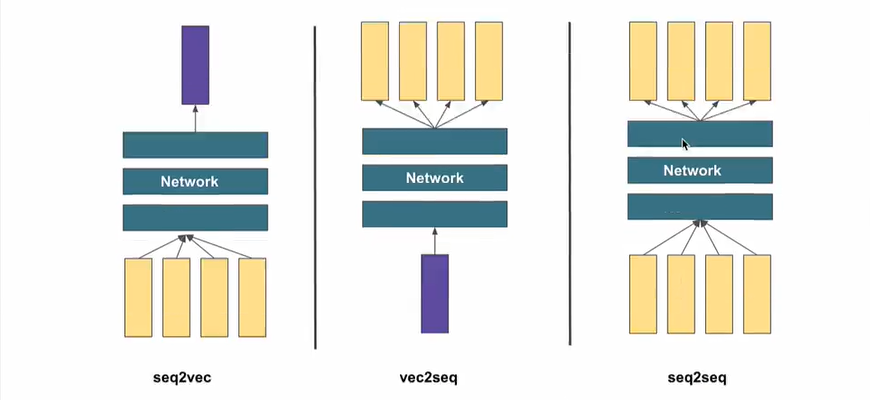

## RNNs and LSTMs in NLP 	
Deep learning architectures for NLP have evolved over time, and it’s important to understand this evolution, especially in the context of Large Language Models (LLMs). Each of these different mappings require different model architecture to accommodate the difference in inputs and outputs. The first large movement of DL models in NLP were leveraging **Recurrent Neural Networks (RNNs)**. These RNN models are flexible and good for problems where input were being mapped to different dimensional outputs, namely shorter sequences. Because of these strengths, RNNs are frequently used for speech recognition problems and voice recognition. However, RNNs can be very timely to train and they don’t perform very well with longer sequences. In order to account for the pitfalls of RNNs, the industry shifted towards **LSTMs** or **Long Short Term Memory** models. These models have memory cells that are much more efficient at maintaining memory for longer sequences, on a scale of hundreds of words. These memory cells help LSTMs perform really well in longer form text problems, however they’re incredibly slow to train because the inputs need to be fed into the network sequentially. As a result of the shortcomings of both RNNs and LSTMs, the transformer architecture was born 


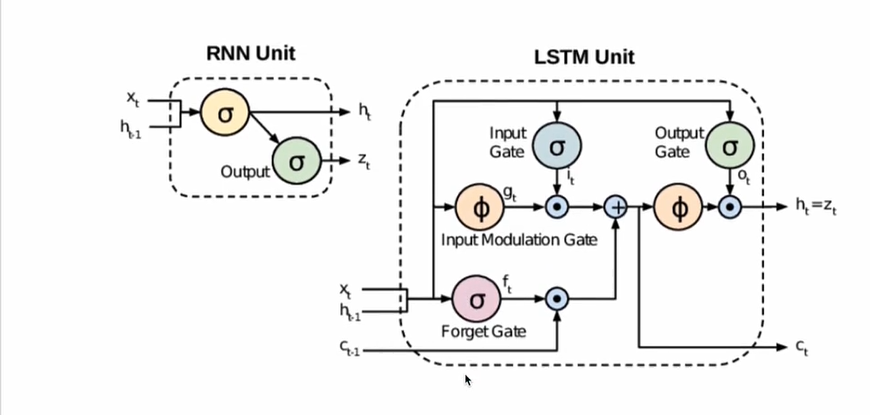

Image courtesy of Data Science Duniya blow. Note that this tutorial is adapted from [this link](https://www.kdnuggets.com/2020/07/pytorch-lstm-text-generation-tutorial.html)

This tutorial will leverage `PyTorch` as the python library to build and train these models from scratch. `PyTorch` is an optimized tensor library specifically for deep learning using GPUs and CPUs. It supports several different deep learning applications, one of which being NLP. 

In addition to the APIs used below, `PyTorch` also has a lighter weight set of APIs called `PyTorch Lightening`. Lightening is designed to be a higher level API on top of the orignial `PyTorch` APIs. The goal of these higher level APIs is to spend less time writing boilerplate code, and mode time modeling. If you're new to deep learning and `PyTorch`, it's recommended to start with the `lightening` APIs and move to the `PyTorch` APIs for any lower level needs. 

In [1]:
import torch
from torch import nn
from torch.autograd import Variable

We'll start by defining an `LSTM` class that will serve as the architecture, initializer, and training module for fitting the model to our data. When we initialize the `LSTM` layer, as a instance of the `LSTM` super class, we can pass several hyperparameters that will be used when fitting the model downstream. For example, in this `LSTM` layer, we'll specify the `input_size`, `hidden_layer` size, `num_layers`, and `dropout` (for regularization) 

In [2]:
class LSTM_Model(nn.Module):
    """
    LSTM model class
    """
    def __init__(self, dataset):
        """
        LSTM Model constructor
        
        @params:
        dataset: dataset used for model training
        
        @returns:
        None
        """
        super(LSTM_Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        """
        Forward module for training 
        
        @params:
        prev_state: torch.Tensor
        
        @returns:
        logits: tuple
        state: tuple
        """
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        """
        Init state
        
        @params:
        sequence_length: int, length of sequence
        
        @returns:
        tuple
        
        """
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

In addition to the `LSTM` class, we'll also need an accompanying `Dataset` class. As part of the `PyTorch` library, the `torch.utils.data.Dataset` data structure is the main mechanism used as a data loader to models. For this example, the `Dataset` class loads the data, caputres the unique words, converts the words to indices, and capture the differnce between the word indices and the sequence length

In [7]:
import torch
import pandas as pd
from collections import Counter

class Dataset(torch.utils.data.Dataset):
    """
    Torch Dataset class for data loading
    """
    def __init__(self,args,):
        """
        Dataset class constructor
        
        @params:
        args: Dict[str, Any]
        
        @returns:
        None
        """
        self.args = args
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        """
        Loading raw files modules 
        
        @parms:
        None
        
        @returns:
        None
        """
        train_df = pd.read_csv(r'D:\\Coding_Stuff\\GitHub\\Natural-Language-Processing\\data\\reddit_clean_jokes.csv')
        text = train_df['Joke'].str.cat(sep=' ')
        return text.split(' ')

    def get_uniq_words(self):
        """
        Retrieving unique words
        
        @params:
        None
        
        @returns:
        None
        
        """
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)
    
    def __len__(self):
        """
        Get length difference between word indices and sequence length
        
        @params:
        None
        
        @return:
        int: difference in length 
        """
        return len(self.words_indexes) - self.args["sequence_length"]

    def __getitem__(self, index):
        """
        Get function 
        
        @params:
        index: int, index
        
        @returns:
        """
        return (
            torch.tensor(self.words_indexes[index:index+self.args["sequence_length"]]),
            torch.tensor(self.words_indexes[index+1:index+self.args["sequence_length"]+1]),
        )

Now that the both the data and model classes have been created, we'll define the main `train` function that facilitated training of the `LSTM`. To summarize the details of this function, based on the number of epochs specificed in model instantiation, batches of data will iterate throught the model in an attempt to minimize the obejective function (`CrossEntropyLoss`)

In [14]:
import argparse
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader

def train(dataset, model, args):
    """
    Main training function 
    
    @params:
    dataset: torch.utils.data.Dataset
    model: LSTM_Model
    args: Dict[str, Any]
    
    @returns:
    None
    """
    model.train()

    dataloader = DataLoader(dataset, batch_size=args["batch_size"])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(args["max_epochs"]):
        state_h, state_c = model.init_state(args["sequence_length"])

        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()
            
            loss.backward()
            optimizer.step()

            if epoch%5 == 0:
                print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

After defining the main training function, a `predict` function is defined to facilitate generating precitions using the model. In order to generate predictions, it's crucial that the data being used for inference, undergoes the exact same preprocessing steps as our training data. The model anticipates data in a specific format and orientation based on training. Since the data preperation has been modularized into the `Dataset` class, we can easily reuse it for both training and inference - limiting the amount of code that needs to be copy and pasted.

In [15]:
def predict(dataset, model, text, next_words=100):
    """
    Generate predictions 
    
    @params:
    dataset: Dataset
    model: LSTM_Model, model 
    text: str
    next_words: int, number of next words to generate
    
    @returns:
    words: list, list of words
    
    """
    model.eval()

    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])
        

    return words

Now that all classes, modules, and functions have been defined we'll:
1. Select a couple baseline arguments - namely `max_epochs`, `batch_size`, and `sequence_length` 
2. Instantiate a `Dataset` object using the arguments 
3. Instantiate a `LSTM_Model` object using the previously created `Dataset` object as an argument 
4. Train the model 
5. Generate and print model predictions for the text *"Knock knock. Whos there?"*

In [16]:
# Define main arguments for training
args = {
    "max_epochs": 10, 
    "batch_size": 265,
    "sequence_length": 4
}


# Instantiate the dataset
dataset = Dataset(args)

# Instantiate the model 
model = LSTM_Model(dataset)

# Train the model using dataset
train(dataset, model, args)
print(predict(dataset, model, text='Knock knock. Whos there?'))

{'epoch': 0, 'batch': 0, 'loss': 8.844581604003906}
{'epoch': 0, 'batch': 1, 'loss': 8.84064769744873}
{'epoch': 0, 'batch': 2, 'loss': 8.830641746520996}
{'epoch': 0, 'batch': 3, 'loss': 8.827138900756836}
{'epoch': 0, 'batch': 4, 'loss': 8.821402549743652}
{'epoch': 0, 'batch': 5, 'loss': 8.8167724609375}
{'epoch': 0, 'batch': 6, 'loss': 8.806281089782715}
{'epoch': 0, 'batch': 7, 'loss': 8.783285140991211}
{'epoch': 0, 'batch': 8, 'loss': 8.765371322631836}
{'epoch': 0, 'batch': 9, 'loss': 8.70069694519043}
{'epoch': 0, 'batch': 10, 'loss': 8.669855117797852}
{'epoch': 0, 'batch': 11, 'loss': 8.487054824829102}
{'epoch': 0, 'batch': 12, 'loss': 8.396167755126953}
{'epoch': 0, 'batch': 13, 'loss': 8.22689151763916}
{'epoch': 0, 'batch': 14, 'loss': 8.011114120483398}
{'epoch': 0, 'batch': 15, 'loss': 7.926202297210693}
{'epoch': 0, 'batch': 16, 'loss': 7.772549152374268}
{'epoch': 0, 'batch': 17, 'loss': 7.697482109069824}
{'epoch': 0, 'batch': 18, 'loss': 7.7414984703063965}
{'epoch

## The Transformer Architecture

Now incredibly common in language models, the **transformer architecture** includes an encoder and decoder architecture where input sequences can be passed in parallel. This parallel processing significantly speeds up training time, especially compared to its RNN and LSTM peers. Transformers also leverages an attention mechanism that captures contextual relationships in sentences. Capturing this context is a huge differentiator for transformer models, it eliminates the long range dependencies of RNNs and LSTMs.  The transformer architecture was yet another shift in the NLP industry.

Architecture courtesy of [*Attention is All You Need*](https://arxiv.org/abs/1706.03762)

Take a look at the next notebook to learn more about using pretrained models with the Transformer Architecture